## Importing the Libraries

In [ ]:
# import the pytorch and debugger libraries
import torch, pdb
# dataloader allows us to build an iterable to hold our training data
from torch.utils.data import DataLoader
# nn helps in building DL architectures
from torch import nn
# computer vision related library
# we can transform our data in different ways
from torchvision import transforms
from torchvision.datasets import MNIST
# a grid of images is used during training to understand
# how fake images are created by the generator, v/s the real imaages
from torchvision.utils import make_grid
# progress bar
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

## Displaying the Grid using a Visualization Function

In [ ]:
# tensor -> multidimensionaal array
# ch -> no. of channels, 1 represents grayscale (black and white)
# num -> number of images displayed
# this function will transform (128 * 784) tensor to (128 * 1 * 28 * 28) tensor
def show(tensor, ch = 1, size = (28, 28), num = 16):
  # detaches the variable from the computation of the gradients
  # we only want what is contained in the variable, we don't wish to process gradients
  # we get it back to the cpu
  # then, view is used for reshaping
  # tensor: 128 (batch size) x 784 (28 * 28 = 784)
  data = tensor.detach().cpu().view(-1, ch, *size) # 128 * 1 * 28 * 28
  # take num = 16 pictures and create a grid of 4 rows
  # permute will change the order of the channels / dimensions
  # 1 * 28 * 28 = 28 * 28 * 1 -> order of dimensions in pytorch and matplotlib are different
  grid = make_grid(data[:num], nrow = 4).permute(1,2,0)
  plt.imshow(grid)
  plt.show()

## Setting up the Parameters and the Hyperparameters 

In [ ]:
epochs = 500
# each step processes 1 batch
curr_step = 0
# at how many steps do we want to show the information
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

# z vector of the latent space
z_dim = 64
# learning rate is the rate at which we push the parameters in the direction of
# the negative gradient while the network learns
lr = 0.00001
# binary cross entropy is the loss function that we'll use
# sigmoid function is applied, then BCE is calculated, to make it more numerically stable
loss_func = nn.BCEWithLogitsLoss()

# batch size
bs = 128
# device where we process the data using parallel processing
device = 'cuda'

# dataloader allows us to build an iterable to hold our training data
# in every epoch, we will shuffle the data
dataloader = DataLoader(MNIST('.', download = True, transform = transforms.ToTensor()), shuffle = True, batch_size = bs)

# no. of steps in each batch = no. of MNIST dataset images / 128 = 60,000 / 128 = 468.75

## Generator Class

In [ ]:
def genBlock(inp, out):
  # sequential will help us set the no. of blocks / layers of elements
  # that will be executed sequentially
  # batch normalization is done on the values which are coming from the previous layer
  # non-linearity (through relu) is needed to make the system identify things more
  # complex than linearity
  # inplace = true will modify the input directly without allocating extra resources
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace = True)
  )

class Generator(nn.Module):
  def __init__(self, z_dim = 64, i_dim = 784, h_dim = 128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), # size -> enters as 64, exits as 128
        genBlock(h_dim, h_dim * 2), # size -> enters as 128, exits as 256 (trying to reach the size of MNIST images)
        genBlock(h_dim * 2, h_dim * 4), # size -> enters as 256, exits as 512
        genBlock(h_dim * 4, h_dim * 8), # size -> enters as 512, exits as 1024
        nn.Linear(h_dim * 8, i_dim), # size -> enters as 1024, exits as 784
        nn.Sigmoid(), # pixel values of the image must be between 0 and 1 (grayscale)
    )

  # forward is executed when we run the instance of the class
  def forward(self, noise):
    return self.gen(noise)

# function to generate noise as many times as we request
def gen_noise(number, z_dim):
  # generate the noise randomly and then store it to the device
  return torch.randn(number, z_dim).to(device)

## Discriminator Class

In [ ]:
def discBlock(inp, out):
  # with relu, there is a risk of dying relu
  # instead of getting a small negative value, we get values on a slope (slope = 0.2, here)
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim = 784, h_dim = 256):
    super().__init__()
    self.disc = nn.Sequential(
        # output has only 1 number, to tell us if the image is real or fake
        discBlock(i_dim, h_dim * 4), # size -> enters as 784, exits as 1024
        discBlock(h_dim * 4, h_dim * 2), # size -> enters as 1024, exits as 512
        discBlock(h_dim * 2, h_dim), # size -> enters as 512, exits as 256
        nn.Linear(h_dim, 1) # enters as 256, exits as 1
    )

  # forward is executed when we run the instance of the class
  # returns the result of passing the image to the discriminator
  def forward(self, image):
    return self.disc(image)

## Structuring the Optimizer

In [ ]:
gen = Generator(z_dim).to(device)
# adam optimizer
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr = lr)

In [ ]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

## Working with Data Iterator

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([5, 5, 3, 4, 1, 8, 2, 7, 7, 8])


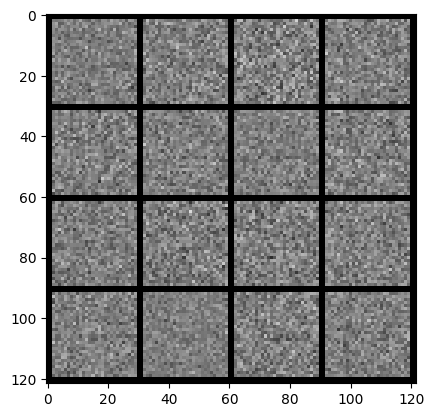

In [ ]:
x, y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

# testing the visualization function
noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

## Loss Functions

In [ ]:
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
  # get the noise vectors
  noise = gen_noise(number, z_dim)
  # pass the vectors through the generator
  fake = gen(noise)
  # pass the fakes which were created by generator, to the discriminator, to get the predictions
  pred = disc(fake)
  # calculate generator loss
  # create tensor with dimensionalities similar to the predictions, and fill it with 1s
  targets = torch.ones_like(pred)
  gen_loss = loss_func(pred, targets)
  return gen_loss

# disc returns both real and fake images
def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
  # get the result of working with the fake images, which are noise vectors
  noise = gen_noise(number, z_dim)
  # pass the vectors through the generator
  fake = gen(noise)
  # when pytorch backpropagates, we don't want to change parameters of the 
  # generator while optimizing the discriminator...this is why detach is used
  disc_fake = disc(fake.detach())
  # calculate discriminator loss
  disc_fake_targets = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake, disc_fake_targets)
  disc_real = disc(real)
  disc_real_targets = torch.ones_like(disc_real)
  disc_real_loss = loss_func(disc_real, disc_real_targets)
  # final loss
  disc_loss = (disc_fake_loss + disc_real_loss) / 2
  return disc_loss

## Training Loop

In [ ]:
# e1 epoch = 469 images
# each steps processes 128 images = size of the batch (except the last step)
for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    # discriminator
    # set all gradients to 0 at the beginning of each step
    disc_opt.zero_grad()
    # get current batch size, which is the length of size of real images 
    cur_bs = len(real) # size of real-> 128 * 1 * 28 * 28
    # reshape the real images to batch size
    real = real.view(cur_bs, -1) # 128 * 784
    real = real.to(device)
    disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real, z_dim)
    # backpropagation
    # retain_graph is optional (used for memory access)
    disc_loss.backward(retain_graph = True)
    disc_opt.step()

    # generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)
    gen_loss.backward(retain_graph = True)
    gen_opt.step()

    # visualization and statistics
    # item transforms the tensor value to a standalone number
    mean_disc_loss = disc_loss.item() / info_step
    mean_gen_loss += gen_loss.item() / info_step
    
    if curr_step % info_step == 0 and curr_step > 0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {curr_step} / Gen loss: {mean_gen_loss} / Disc loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss = 0, 0
    curr_step += 1